## Caricamento moduli richiesti

In [128]:
import torch
from torch.utils import data
from os.path import join
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import transforms
import pickle
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from os.path import join
import os
import torch_directml  #Opzionale per usare qualsiasi GPU durante il training
from matplotlib import pyplot as plt
from dotenv import load_dotenv 


## Caricamento variabili d'ambiente

In [129]:
load_dotenv(override=True) #Rieseguire se si apportano modifiche all'env

True

## Classe per caricare il dataset da CSV

In [130]:

class CSVImageDataset(data.Dataset):
    def __init__(self, data_root, csv, transform=None):
        self.data_root = data_root
        self.data = pd.read_csv(csv)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        im_path, im_label = self.data.iloc[i]['Path'], self.data.iloc[i].Label
        # Eventuale conversione di immagini in RGB
        im = Image.open(join(self.data_root, im_path)).convert('RGB')
        
        # Applica composizione di trasformazioni
        if self.transform is not None:
            im = self.transform(im)
        
        return im, im_label

In [131]:
def salva_valori_su_file(valori, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(valori, file)

def leggi_valori_da_file(file_path):
    with open(file_path, 'rb') as file:
        valori = pickle.load(file)
    return valori

In [132]:
resolution=640

file_path=os.getenv("PATH_MEAN_STD")

#******** SE ESISTE UN FILE CON VALORI PRECALCOLATI USA QUELLI********
if os.path.exists(file_path):
    valori = leggi_valori_da_file(file_path)
    print("Valori letti dal file:", valori)
    red_mean=valori[0]
    green_mean=valori[1]
    blue_mean=valori[2]
    red_std=valori[3]
    green_std=valori[4]
    blue_std=valori[5]
else:

    os.makedirs("bin",exist_ok=True)
    
    preprocessing_trasnform = transforms.Compose([
    transforms.Resize((resolution,resolution)),
    transforms.ToTensor(),
    ])

    dataset_train=CSVImageDataset(os.getenv("PATH_TRAIN_IMAGES"),os.getenv("PATH_TRAIN_CSV"),transform=preprocessing_trasnform)
    dataset_valid=CSVImageDataset(os.getenv("PATH_VALID_IMAGES"),os.getenv("PATH_VALID_CSV"),transform=preprocessing_trasnform)
    dataset_test=CSVImageDataset(os.getenv("PATH_TEST_IMAGES"),os.getenv("PATH_TEST_CSV"),transform=preprocessing_trasnform)

    red_mean=0
    green_mean=0
    blue_mean=0
    num_pixel=(len(dataset_train)*(resolution)**2)
    for image in dataset_train:
        red_mean+=image[0][0].sum()# somma di tutti i pixel
        green_mean+=image[0][1].sum()# somma di tutti i pixel
        blue_mean+=image[0][2].sum()# somma di tutti i pixel
    #dividiamo per il numero di immagini molt numero di pixel
    red_mean=red_mean/num_pixel
    green_mean=green_mean/num_pixel
    blue_mean=blue_mean/num_pixel

    #Calcolo della deviazione standard
    red_std=0
    green_std=0
    blue_std=0
    for image in dataset_train:
        red_std+=((image[0][0]-red_mean)**2).sum()
        green_std+=((image[0][1]-green_mean)**2).sum()
        blue_std+=((image[0][2]-blue_mean)**2).sum()
    #sqrt della varianza
    red_std=np.sqrt(red_std/num_pixel)
    green_std=np.sqrt(green_std/num_pixel)
    blue_std=np.sqrt(blue_std/num_pixel)

    valori=[red_mean,green_mean,blue_mean,red_std,green_std,blue_std]
    salva_valori_su_file(valori, file_path)
    print("Valori calcolati e salvati:", valori)

Valori letti dal file: [tensor(0.6095), tensor(0.5478), tensor(0.4684), tensor(0.2324), tensor(0.2478), tensor(0.2655)]


In [133]:
test_transform = transforms.Compose([
    transforms.Resize(640),
    transforms.ToTensor(),
    transforms.Normalize([red_mean, green_mean, blue_mean], [red_std, green_std, blue_std])
])

dataset_test=CSVImageDataset(os.getenv("PATH_TEST_IMAGES"),os.getenv("PATH_TEST_CSV"),transform=test_transform)

test_loader=(DataLoader(dataset_test,batch_size=16,num_workers=0))


## SQUEEZENET (NO FINETUNING)

In [134]:
checkpoint=torch.load(os.getenv("PATH_SQUEEZENET_BEST"),map_location='cpu')
squeezenet_regression=checkpoint["model"]

In [135]:
def test_classifier(model,loader):
    #device=dml
    model.to('cpu')
    predictions,labels=[],[]
    n=0
    model.eval()
    for batch in loader:
        x=batch[0].to('cpu')
        y=batch[1].to('cpu')
        output=model(x) 
        n+=x.shape[0]
        output.detach()
        y.detach()
        preds=(output.view(-1).to('cpu')).detach().numpy()
        labs=(y.to('cpu')).detach().numpy()
        predictions.extend(list(preds))
        labels.extend(list(labs))
    return np.array(predictions),np.array(labels)

In [136]:
def rec_curve(predictions,gt):
    assert predictions.shape==gt.shape
    #MAE
    errors =np.abs((predictions-gt))
    tolerances=sorted(np.unique(errors)) #Prende gli le occorrenze uniche di errore
    correct=[]
    for t in tolerances: #Uso le occorrenze prese prima come tolleranza
        correct.append((errors<=t).mean())#Correttamente regressi rispetto alla tolleranza in questione
    AUC= np.trapz(correct,tolerances)#Area sotto la curva con metodo dei trapezi
    tot_area=np.max(tolerances)*1 #Area totale
    AOC=tot_area-AUC #Area sopra la curva
    #Restituiamo le soglie, la frazione di campioni corr. regressi e l'area sopra la curva
    return tolerances,correct,AOC

In [137]:
predictions,labels=test_classifier(squeezenet_regression,test_loader)

In [138]:
print("Mean Squared Error MSE di test: {:0.2f}".format(((predictions-labels)**2).mean()))
print("Mean Squared Error RMSE di test: {:0.2f}".format((((predictions-labels)**2).mean())**(1/2)))
print("Mean Squared Error MAE di test: {:0.2f}".format(abs(predictions-labels).mean()))

Mean Squared Error MSE di test: 4.92
Mean Squared Error RMSE di test: 2.22
Mean Squared Error MAE di test: 1.02


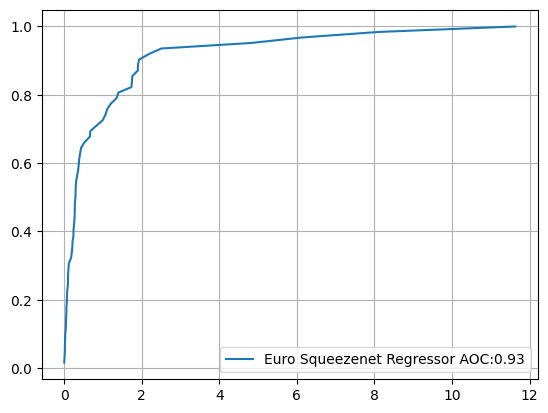

In [139]:
squeezenet_rec=rec_curve(predictions,labels)
plt.plot(squeezenet_rec[0],squeezenet_rec[1])
plt.legend(["Euro Squeezenet Regressor AOC:%0.2f"%squeezenet_rec[2]])
plt.grid()
plt.show()

## SQUEEZENET

In [140]:
checkpoint=torch.load(os.getenv("PATH_SQUEEZENET_PRETRAINED_BEST"),map_location='cpu')
squeezenet_pretrained_regression=checkpoint["model"]

In [141]:
predictions,labels=test_classifier(squeezenet_pretrained_regression,test_loader)

In [142]:
print("Mean Squared Error MSE di test: {:0.2f}".format(((predictions-labels)**2).mean()))
print("Mean Squared Error RMSE di test: {:0.2f}".format((((predictions-labels)**2).mean())**(1/2)))
print("Mean Squared Error MAE di test: {:0.2f}".format(abs(predictions-labels).mean()))

Mean Squared Error MSE di test: 9.25
Mean Squared Error RMSE di test: 3.04
Mean Squared Error MAE di test: 1.10


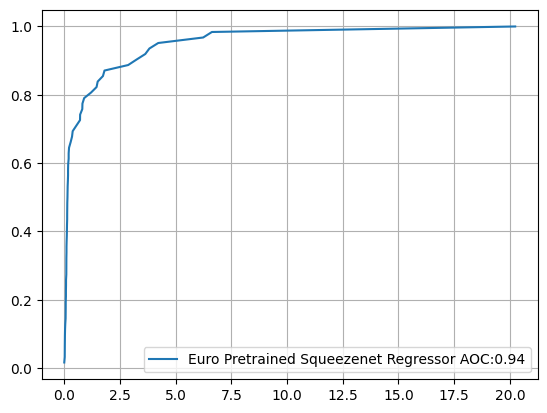

In [143]:
squeezenet_pretrained_rec=rec_curve(predictions,labels)
plt.plot(squeezenet_pretrained_rec[0],squeezenet_pretrained_rec[1])
plt.legend(["Euro Pretrained Squeezenet Regressor AOC:%0.2f"%squeezenet_pretrained_rec[2]])
plt.grid()
plt.show()

## RESNET

In [144]:
checkpoint=torch.load(os.getenv("PATH_RESNET_BEST"),map_location='cpu')
resnet_regression=checkpoint["model"]

In [145]:
predictions,labels=test_classifier(resnet_regression,test_loader)

In [146]:
print("Mean Squared Error MSE di test: {:0.2f}".format(((predictions-labels)**2).mean()))
print("Mean Squared Error RMSE di test: {:0.2f}".format((((predictions-labels)**2).mean())**(1/2)))
print("Mean Squared Error MAE di test: {:0.2f}".format(abs(predictions-labels).mean()))

Mean Squared Error MSE di test: 6.70
Mean Squared Error RMSE di test: 2.59
Mean Squared Error MAE di test: 0.69


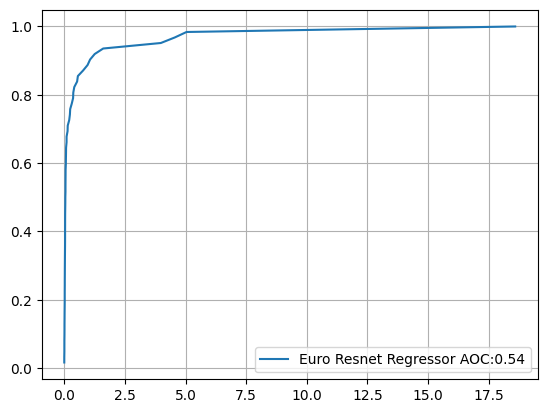

In [147]:
resnet_rec=rec_curve(predictions,labels)
plt.plot(resnet_rec[0],resnet_rec[1])
plt.legend(["Euro Resnet Regressor AOC:%0.2f"%resnet_rec[2]])
plt.grid()
plt.show()

## CONFRONTO DELLE PERFORMANCE CON CURVE REC

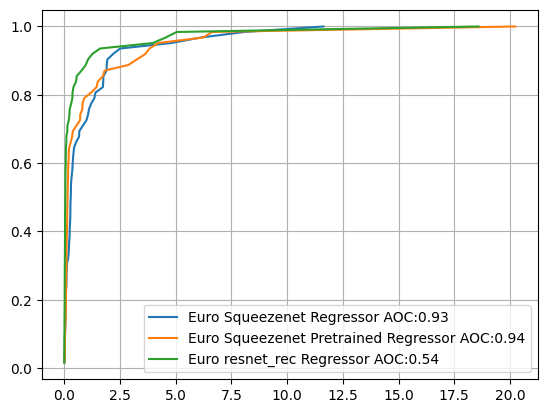

In [148]:
plt.plot(squeezenet_rec[0],squeezenet_rec[1])
plt.plot(squeezenet_pretrained_rec[0],squeezenet_pretrained_rec[1])
plt.plot(resnet_rec[0],resnet_rec[1])
plt.legend(["Euro Squeezenet Regressor AOC:%0.2f"%squeezenet_rec[2],
            "Euro Squeezenet Pretrained Regressor AOC:%0.2f"%squeezenet_pretrained_rec[2],
            "Euro resnet_rec Regressor AOC:%0.2f"%resnet_rec[2]])
plt.grid()
plt.show()